Trabalho 

In [1]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prep3 import DataPreparation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

In [2]:
prep = DataPreparation()

train_db = pd.read_csv("dataset/train_radiomics_hipocamp.csv")
test_db = pd.read_csv("dataset/test_radiomics_hipocamp.csv")
control_db = pd.read_csv("dataset/train_radiomics_occipital_CONTROL.csv")

train_db = prep.prep_train(train_db)
test_db = prep.transform(test_db)
control_db = prep.transform(control_db)

In [3]:
train_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 2162 entries, diagnostics_Image-original_Dimensionality to Transition
dtypes: float64(2161), object(1)
memory usage: 5.0+ MB


In [4]:
test_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 2161 entries, diagnostics_Image-original_Dimensionality to Age
dtypes: float64(2161)
memory usage: 1.6 MB


In [5]:
X = train_db.drop(columns=["Transition"]) 
y = train_db["Transition"]  

In [6]:
X_train = pd.read_csv('prep3/train_X.csv')
X_test = pd.read_csv('prep3/test_X.csv')
y_train = pd.read_csv('prep3/train_y.csv')
y_test = pd.read_csv('prep3/test_y.csv')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Melhores parâmetros encontrados: {'learning_rate': 1, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
F1 Score médio com validação cruzada: 0.322003668936917


/home/tiagogr/miniconda3/envs/DAA/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Matriz de Confusão:


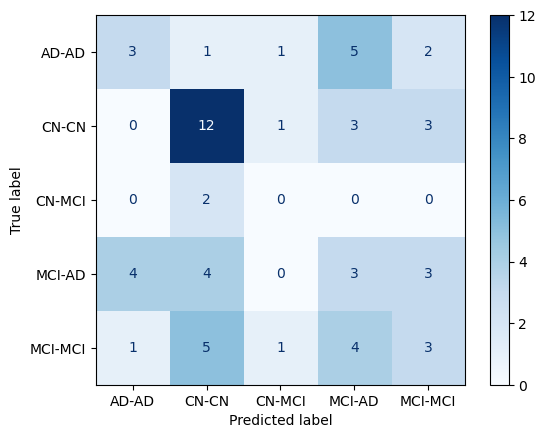


Relatório de Classificação:
              precision    recall  f1-score   support

       AD-AD       0.38      0.25      0.30        12
       CN-CN       0.50      0.63      0.56        19
      CN-MCI       0.00      0.00      0.00         2
      MCI-AD       0.20      0.21      0.21        14
     MCI-MCI       0.27      0.21      0.24        14

    accuracy                           0.34        61
   macro avg       0.27      0.26      0.26        61
weighted avg       0.34      0.34      0.34        61



In [10]:
clf = GradientBoostingClassifier(random_state=2024)

param_grid = {
    'n_estimators': [100],
    'learning_rate': [1],
    'max_depth': [10],
    'min_samples_leaf': [2],
    'min_samples_split': [5],
}

cv_strategy = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='f1_macro',  
    cv=cv_strategy,        
    verbose=1,              
    refit=True,
    n_jobs=8
)

grid_search.fit(X, y)

print("Melhores parâmetros encontrados:", grid_search.best_params_)

best_model = grid_search.best_estimator_

print("F1 Score médio com validação cruzada:", grid_search.best_score_)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Matriz de Confusão:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

F1-Score no conjunto de controle: 0.19186055725738949


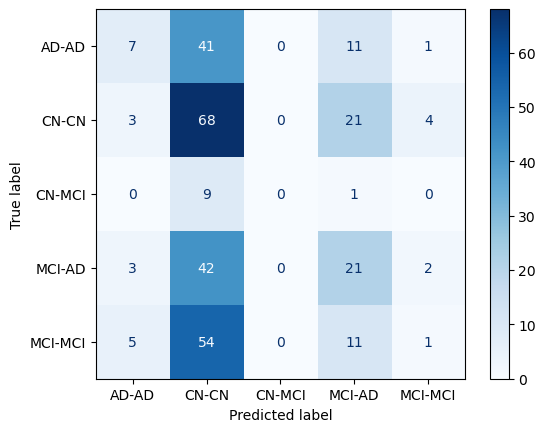


Relatório de Classificação no conjunto de controle:
              precision    recall  f1-score   support

       AD-AD       0.39      0.12      0.18        60
       CN-CN       0.32      0.71      0.44        96
      CN-MCI       0.00      0.00      0.00        10
      MCI-AD       0.32      0.31      0.32        68
     MCI-MCI       0.12      0.01      0.03        71

    accuracy                           0.32       305
   macro avg       0.23      0.23      0.19       305
weighted avg       0.28      0.32      0.25       305



/home/tiagogr/miniconda3/envs/DAA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiagogr/miniconda3/envs/DAA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiagogr/miniconda3/envs/DAA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [12]:
CX = control_db.drop(columns=["Transition"]) 
Cy = control_db["Transition"]  

control_pred = best_model.predict(CX)

control_f1_score = f1_score(Cy, control_pred, average='macro')
print("F1-Score no conjunto de controle:", control_f1_score)

# Matriz de Confusão
ConfusionMatrixDisplay.from_predictions(Cy, control_pred, cmap='Blues')
plt.show()

# Relatório de Classificação
print("\nRelatório de Classificação no conjunto de controle:")
print(classification_report(Cy, control_pred))

### Guardar o melhor modelo do Gradient Bosst

In [52]:
best_model.fit(X, y)
test_predictions = best_model.predict(test_db)

row_ids = range(1, len(test_predictions) + 1)

output_df = pd.DataFrame({
    "RowId": row_ids,
    "Result": test_predictions
})


output_df.to_csv("resultados/gb3.csv", index=False)